In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import torchvision.io as io

False

In [65]:
# Steps:
## Create training and validation datasets from files.
## Create data loaders for each dataset
class SDSSImagery(Dataset):
    def __init__(self, labels, transform=None):
        self.img_labels = pd.read_csv(labels, dtype={'image_filepath': 'str', 'Hubble_coarse' : 'category'})
        self.img_labels['Hubble_coarse_encoded'] = self.img_labels['Hubble_coarse'].cat.codes.astype('category')
        self.transform = transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.img_labels.iloc[idx, 0]
        image = io.read_image(img_name)
        image = image / 255
        label = self.img_labels.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)
        return image, label

In [66]:
dataset = SDSSImagery(labels='image_labels.csv')
train_ds, val_ds = random_split(dataset, [0.8, 0.2])

batch_size = 64
train_dataloader = DataLoader(train_ds, batch_size, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size, shuffle=True)

In [67]:
image_size = 256
num_classes = 4
BasicCNN = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(16, 32, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Dropout(0.3),
    nn.Linear(int((64*(image_size**2)) / (4**3)), 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes),
)

# Read number of classes and image size from data?

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(BasicCNN.parameters())

In [68]:
def train_one_epoch(model, loss_fn, optimizer, train_dataloader, report_interval_batches=100000000):
    running_loss = 0
    last_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % report_interval_batches == report_interval_batches - 1:
            last_loss = running_loss / report_interval_batches
            print(' batch {} loss: {}'.format(i+i, last_loss), end='\x1b[1K\r')
            running_loss = 0.0
    return last_loss


In [69]:
def train_model(model, loss_fn, optimizer, train_dataloader, val_dataloader, epochs, patience, model_path):
    # model:
    best_vloss = float('inf')
    failed_to_improve = 0
    train_loss_history = []
    val_loss_history = []
    for epoch in range(epochs):
        print('EPOCH {}'.format(epoch+1))
        model.train(True)
        avg_loss = train_one_epoch(model, loss_fn, optimizer, train_dataloader, 1)
        train_loss_history.append(avg_loss)

        running_vloss = 0
        model.eval()
        with torch.no_grad():
            for i, vdata in enumerate(val_dataloader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels.long())
                running_vloss += vloss

        avg_vloss = running_vloss / (i+1)
        val_loss_history.append(avg_vloss)

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), model_path)
        else:
            failed_to_improve += 1

        if failed_to_improve >= patience:
            break
    print('Finished Training')
    history_df = pd.DataFrame({'Training loss' : train_loss_history, 'Validation loss' : val_loss_history})
    history_df.plot()
    return train_loss_history, val_loss_history


EPOCH 1
LOSS train 1.0138254165649414 valid 0.8757760524749756
EPOCH 2
LOSS train 0.8444961309432983 valid 0.7637312412261963
EPOCH 3
LOSS train 0.6558870077133179 valid 0.7334235906600952
EPOCH 4
LOSS train 0.7386036515235901 valid 0.7093855142593384
EPOCH 5
LOSS train 0.5957022309303284 valid 0.7129086852073669
EPOCH 6
LOSS train 0.5016586184501648 valid 0.7792969942092896
EPOCH 7
LOSS train 0.43886372447013855 valid 0.7528324723243713
EPOCH 8
LOSS train 0.4814940392971039 valid 0.829490065574646
EPOCH 9
LOSS train 0.3364701271057129 valid 0.8822378516197205
EPOCH 10
LOSS train 0.5072190165519714 valid 0.9855236411094666
EPOCH 11
LOSS train 0.2718682587146759 valid 1.1346805095672607
EPOCH 12
LOSS train 0.31837427616119385 valid 1.2078574895858765
EPOCH 13
LOSS train 0.5319802165031433 valid 1.248651385307312
EPOCH 14
LOSS train 0.2022397369146347 valid 1.465358853340149
Finished Training


([1.0138254165649414,
  0.8444961309432983,
  0.6558870077133179,
  0.7386036515235901,
  0.5957022309303284,
  0.5016586184501648,
  0.43886372447013855,
  0.4814940392971039,
  0.3364701271057129,
  0.5072190165519714,
  0.2718682587146759,
  0.31837427616119385,
  0.5319802165031433,
  0.2022397369146347],
 [tensor(0.8758),
  tensor(0.7637),
  tensor(0.7334),
  tensor(0.7094),
  tensor(0.7129),
  tensor(0.7793),
  tensor(0.7528),
  tensor(0.8295),
  tensor(0.8822),
  tensor(0.9855),
  tensor(1.1347),
  tensor(1.2079),
  tensor(1.2487),
  tensor(1.4654)])

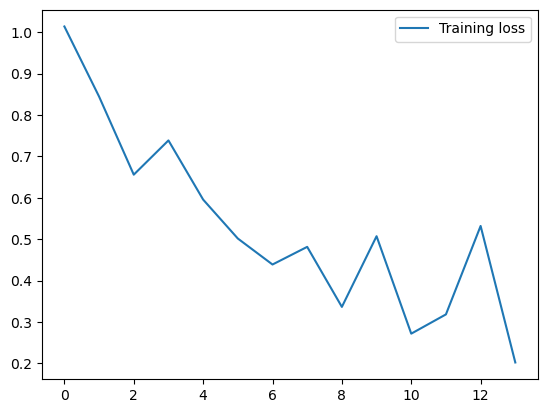

In [72]:
train_model(BasicCNN, loss_fn, optimizer, train_dataloader, val_dataloader, 150, 10, 'models/torch/BasicCNN')